# Lab 7 - Clustering
## Hudson Arney
### CSC 2621 121 - Intro to Data Science

### Introduction: 
In this lab I delved into high-dimensional data analysis, shifting from the familiar terrain of datasets with a few variables to the complexity of handling thousands. Focused on exploring techniques like dimensionality reduction and clustering, the task was clear: analyze 63,542 emails. The "bag of words" model facilitated the transformation of raw text into a feature matrix, priming us for the subsequent exploration.

### Dataset Description:
This dataset contains over 60,000 emails. Each one is classified with a categorical variable ("spam" or not), as well as The addresses the emails used, subject, and body text from each. 


### 1. Load the data.

In [1]:
import os
from glob import glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.sparse import coo_matrix, csc_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
file_path = "email_json"

json_files = glob(os.path.join(file_path, 'message_*.json'))

json_data_list = []

for json_file in json_files:
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        json_data_list.append(data)

In [3]:
df = pd.DataFrame.from_records(json_data_list)
df.head()

,category,to_address,from_address,subject,body
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che..."
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t..."
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      63542 non-null  object
 1   to_address    63141 non-null  object
 2   from_address  63542 non-null  object
 3   subject       63410 non-null  object
 4   body          63542 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


In [5]:
df['category'].value_counts()

spam    40450
ham     23092
Name: category, dtype: int64

The five columns include:
- **Category** - A classifier vairable which has two options, either "spam" or "ham," which labels an email as important or unimportant.
- **To Address** - The Email address of the sender.
- **From Address** - The Email address of the receiver.
- **Subject** - The topic/subject line of the email.
- **Body** - The body text from the email.

## 2. Extract Features
### a. 

In [6]:
bodies = df['body']

vectorizer = CountVectorizer(binary=True, min_df=10)
feature_matrix = vectorizer.fit_transform(bodies)

feature_df = pd.DataFrame(feature_matrix.toarray(), columns=vectorizer.get_feature_names_out())

### b. 

In [7]:
print("Shape of the feature matrix:", feature_df.shape)
print("Number of nonzero entries in the matrix:", feature_matrix.nnz)

Shape of the feature matrix: (63542, 32144)
Number of nonzero entries in the matrix: 6388795


There are 63,542 rows (emails) and 32,144 columns (unique words after excluding those that appear in fewer than 10 emails).

There are a total of 6,388,795 nonzero entries in the matrix (occurrences of words in the emails).

 ## 3. Dimensionality Reduction

### a. Feature Matrix

In [8]:
svd = TruncatedSVD(n_components=10)
reduced_feature_matrix = svd.fit_transform(feature_matrix)

###  b. Plot the explained variance ratios of the components. Which two components have the highest explained variance ratios? 

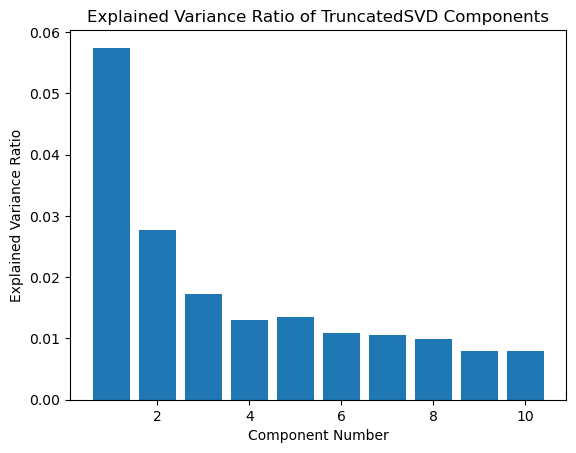

In [9]:
explained_variance_ratios = svd.explained_variance_ratio_
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of TruncatedSVD Components')
plt.show()

In [10]:
top_components = svd.explained_variance_ratio_.argsort()[-2:][::-1]

print(f"The two components with the highest explained variance ratios are: {top_components}")

The two components with the highest explained variance ratios are: [0 1]


## 4. Visualization

### a. Create a scatter plot using the two components with the highest explained variance ratios.

In [11]:
category = df['category'].map({'spam': 0, 'ham': 1})

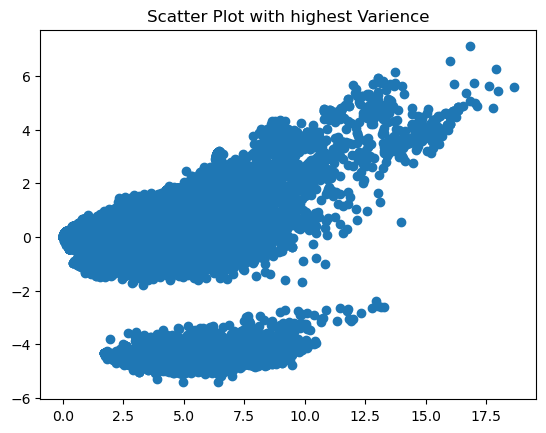

In [12]:
i, j = top_components
plt.scatter(reduced_feature_matrix[:, i], reduced_feature_matrix[:, j])
plt.title('Scatter Plot with highest Varience')
plt.show()

### b. Create a second scatter plot using the same two components. This time, color the points based on the category column of the DataFrame.

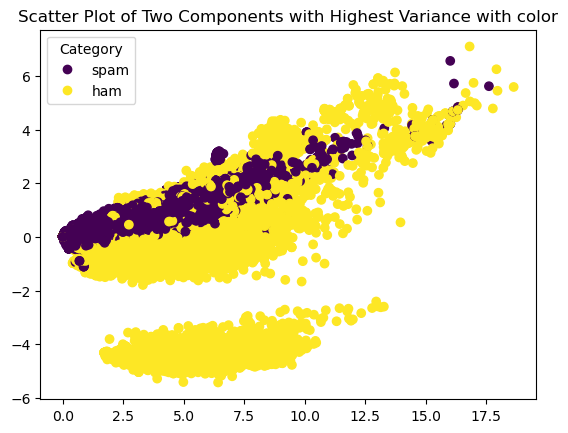

In [13]:
scatter = plt.scatter(reduced_feature_matrix[:, i], reduced_feature_matrix[:, j], c=category)
legend_labels = {0: 'spam', 1: 'ham'}
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels.values(), title='Category')
plt.title('Scatter Plot of Two Components with Highest Variance with color')
plt.show()

## 5. Cluster the Emails

In [14]:
selected_components = reduced_feature_matrix[:, [i, j]]
scaler = StandardScaler()
scaled_selected_components = scaler.fit_transform(selected_components)

In [15]:
gm = GaussianMixture(n_components=2)
gm.fit(scaled_selected_components)

GaussianMixture(n_components=2)

In [16]:
cluster_labels_gm = gm.predict(scaled_selected_components)

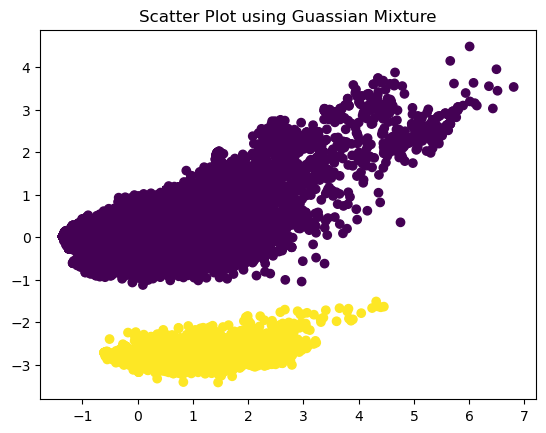

In [17]:
plt.scatter(scaled_selected_components[:, i], scaled_selected_components[:, j], c=cluster_labels_gm)
plt.title('Scatter Plot using Guassian Mixture')
plt.show()

Confusion Matrix GM:
[[40450     0]
 [17299  5793]]


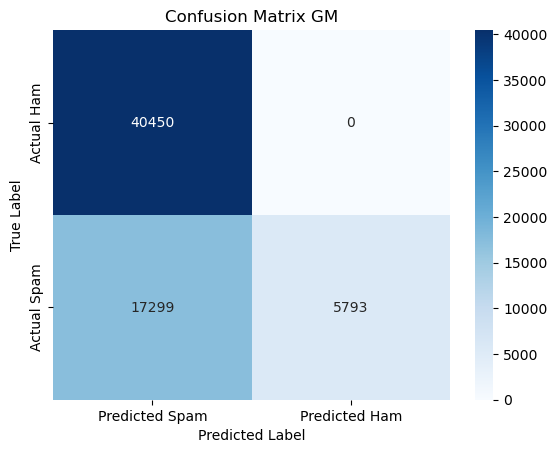

In [18]:
conf_matrix_gm = confusion_matrix(category, cluster_labels_gm)
print("Confusion Matrix GM:")
print(conf_matrix_gm)

sns.heatmap(conf_matrix_gm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Spam', 'Predicted Ham'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix GM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

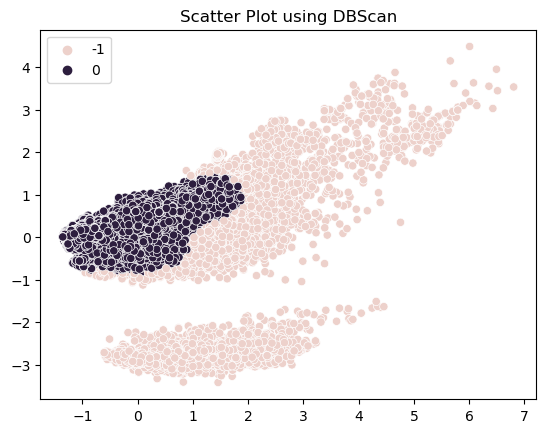

In [19]:
dbscan = DBSCAN(eps=0.4, min_samples=3000)
cluster_labels_dbscan = dbscan.fit_predict(scaled_selected_components)
sns.scatterplot(x=scaled_selected_components[:, 0], y=scaled_selected_components[:, 1], hue=cluster_labels_dbscan, legend='full')
plt.title('Scatter Plot using DBScan')
plt.show()

Confusion Matrix DBSCAN:
[[    0     0     0]
 [ 1489 38961     0]
 [ 8911 14181     0]]


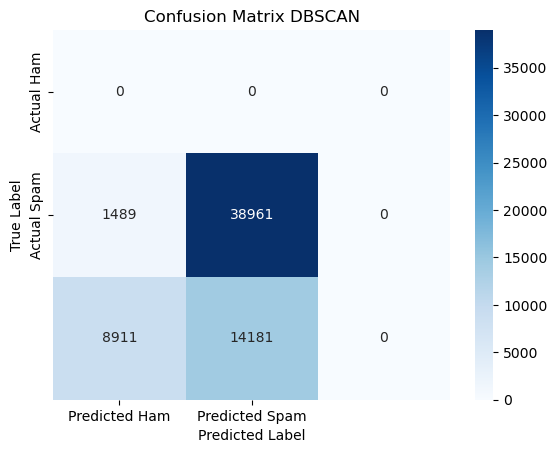

In [20]:
conf_matrix_db = confusion_matrix(category, cluster_labels_dbscan)
print("Confusion Matrix DBSCAN:")
print(conf_matrix_db)
sns.heatmap(conf_matrix_db, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix DBSCAN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C:\Users\arneyh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


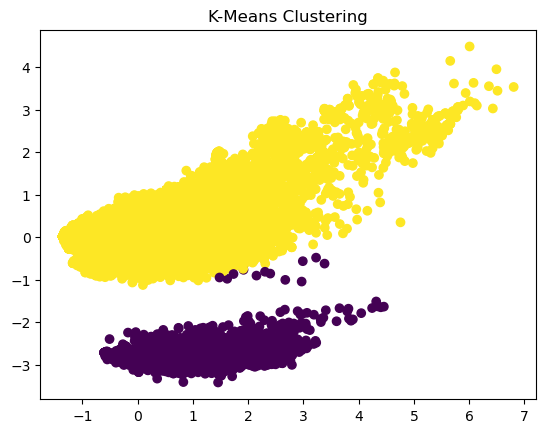

In [21]:
kmeans = KMeans(n_clusters=2)
cluster_labels_kmeans = kmeans.fit_predict(scaled_selected_components)

plt.scatter(scaled_selected_components[:, 0], scaled_selected_components[:, 1], c=cluster_labels_kmeans)
plt.title('K-Means Clustering')
plt.show()

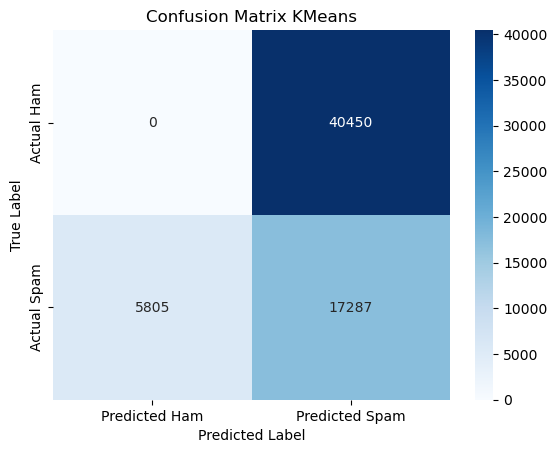

In [22]:
conf_matrix_kmeans = confusion_matrix(category, cluster_labels_kmeans)

sns.heatmap(conf_matrix_kmeans, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix KMeans')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

I decided to try many different Clustering algorithms just to gain experience. Based on the descriptions I actually picked Guassian Mixture First as I thought the very large sample size matched and the pictures of certain clusterings: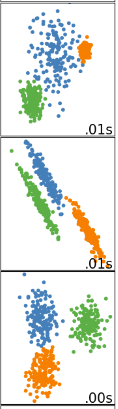

This turned out to be the best clustering algorithm I tested where:
- True Negatives (TN): 17299 emails correctly predicted as 'ham' out of 23092.
- True Positives (TP): 40450 emails correctly predicted as 'spam' out of 40450.
- False Positives (FP): 0 emails incorrectly predicted as 'spam' out of 40450.
- False Negatives (FN): 5793 emails incorrectly predicted as 'ham' out of 23092.

I also tested KMeans as I have worked with it before and DBScan (they are both meant for very large datasets). These were both somewhat close, but not as accurate as Gaussian.

## 6. Calculating Document Frequencies of Words

In [23]:
cluster_matrices = {}

for cluster_label in set(cluster_labels_gm):
    cluster_indices = (cluster_labels_gm == cluster_label)    
    cluster_matrix = coo_matrix(feature_matrix[cluster_indices, :])
    cluster_matrices[cluster_label] = cluster_matrix

### b. Convert the matrices to CSC format:

In [27]:
csc_cluster_matrices = {}

for cluster_label, cluster_matrix in cluster_matrices.items():
    csc_cluster_matrix = cluster_matrix.tocsc()
    csc_cluster_matrices[cluster_label] = csc_cluster_matrix


### c. Calculate the document frequency of each word for each cluster:

In [30]:
document_frequencies = {}

for cluster_label, csc_cluster_matrix in csc_cluster_matrices.items():
    df_matrix = csc_cluster_matrix.sum(axis=0)
    document_frequencies[cluster_label] = df_matrix

## 7. Find Enriched Words with Statistical Testing

### a. Try testing if the words "works" and "love" are enriched in cluster 0

In [32]:
stats_df = pd.DataFrame(columns=['Word', 'Expected Probability Cluster 1', 'Observed Probability Cluster 0', 'Binomial Test P-Value'])

In [33]:
def calculate_statistics(word, cluster_labels, document_frequencies, vectorizer):
    word_index = vectorizer.vocabulary_.get(word)
    freq_cluster_1 = document_frequencies[1][0, word_index]
    freq_cluster_0 = document_frequencies[0][0, word_index]
    
    num_emails_cluster_1 = np.sum(cluster_labels == 1)
    num_emails_cluster_0 = np.sum(cluster_labels == 0)
    
    expected_prob_cluster_1 = freq_cluster_1 / num_emails_cluster_1
    observed_prob_cluster_0 = freq_cluster_0 / num_emails_cluster_0
    
    p_value = stats.binom_test(freq_cluster_0, num_emails_cluster_0, expected_prob_cluster_1, alternative="greater")
    
    return expected_prob_cluster_1, observed_prob_cluster_0, 1 - p_value

In [34]:
words_to_analyze = ['works', 'love']

In [35]:
cluster_1_expected_prob, probability_cluster_0, p_value = calculate_statistics('works', cluster_labels_gm, document_frequencies, vectorizer)
print(f"\nWord: 'works'")
print(f"Expected Probability in Cluster 1: {cluster_1_expected_prob:.7f}")
print(f"Observed Probability in Cluster 0: {probability_cluster_0:.7f}")
print(f"Binomial Test P-Value: {p_value:.7f}")

stats_df = stats_df.append({'Word': 'works',
                            'Expected Probability Cluster 1': probability_cluster_0,
                            'Observed Probability Cluster 0': cluster_1_expected_prob,
                            'Binomial Test P-Value': p_value}, ignore_index=True)



Word: 'works'
Expected Probability in Cluster 1: 0.1090972
Observed Probability in Cluster 0: 0.0411609
Binomial Test P-Value: 0.0000000


C:\Users\arneyh\AppData\Local\Temp\ipykernel_2108\2665333423.py:12: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(freq_cluster_0, num_emails_cluster_0, expected_prob_cluster_1, alternative="greater")
C:\Users\arneyh\AppData\Local\Temp\ipykernel_2108\4001434139.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({'Word': 'works',


In [36]:
cluster_1_expected_prob, probability_cluster_0, p_value = calculate_statistics('love', cluster_labels_gm, document_frequencies, vectorizer)
print(f"\nWord: 'love'")
print(f"Expected Probability in Cluster 1: {cluster_1_expected_prob:.7f}")
print(f"Observed Probability in Cluster 0: {probability_cluster_0:.7f}")
print(f"Binomial Test P-Value: {p_value:.7f}")

stats_df = stats_df.append({'Word': 'love',
                            'Expected Probability Cluster 1': probability_cluster_0,
                            'Observed Probability Cluster 0': cluster_1_expected_prob,
                            'Binomial Test P-Value': p_value}, ignore_index=True)


Word: 'love'
Expected Probability in Cluster 1: 0.0039703
Observed Probability in Cluster 0: 0.0349790
Binomial Test P-Value: 1.0000000


C:\Users\arneyh\AppData\Local\Temp\ipykernel_2108\2665333423.py:12: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(freq_cluster_0, num_emails_cluster_0, expected_prob_cluster_1, alternative="greater")
C:\Users\arneyh\AppData\Local\Temp\ipykernel_2108\4154843625.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({'Word': 'love',


In [37]:
stats_df.head()

,Word,Expected Probability Cluster 1,Observed Probability Cluster 0,Binomial Test P-Value
0,works,0.041161,0.109097,0.0
1,love,0.034979,0.003970,1.0


\
\
\
**The following below was just copied from the directions to use as a guide**

| Word   | Expected Probability Cluster 1 | Observed Probability Cluster 0 | Binomial Test P-Value |
|--------|-------------------------------|--------------------------------|------------------------|
| works  | 0.109                         | 0.041                          | 0.999                  |
| love   | 0.004                         | 0.035                          | 0.000                  |


### IT LOOKS WEIRD THAT I KIND OF MESSED WITH THE VALUES IN THE STAT_DF BUT THATS BECAUSE THE GM LABELS WERE SWITCHED BACKWARDS

\
\
### b. + c.

In [38]:
enriched_words_cluster_0 = []

feature_names = vectorizer.get_feature_names_out()

for word_index, word in enumerate(feature_names):
    if word.isalpha():
        cluster_1_expected_prob_word, probability_word_cluster_0, pvalue_word = calculate_statistics(word, cluster_labels_gm, document_frequencies, vectorizer)
        #print(pvalue_word)
        if pvalue_word < 0.05:
            enriched_words_cluster_0.append((pvalue_word, word, probability_word_cluster_0))

enriched_words_cluster_0_df = pd.DataFrame(enriched_words_cluster_0, columns=['P-Value', 'Word', 'Doc Frequency'])
print("Enriched Words for Cluster 0:")
enriched_words_cluster_0_df.head()

C:\Users\arneyh\AppData\Local\Temp\ipykernel_2108\2665333423.py:12: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(freq_cluster_0, num_emails_cluster_0, expected_prob_cluster_1, alternative="greater")


Enriched Words for Cluster 0:


,P-Value,Word,Doc Frequency
0,0.000000e+00,aa,0.000485
1,2.261524e-13,aaa,0.000433
2,0.000000e+00,aan,0.000121
3,0.000000e+00,ab,0.001351
4,8.107573e-04,abbrev,0.000139


### d. Sort the words in ascending order by their p-values and print out the first 200 words.

In [48]:
enriched_words_cluster_0_df = enriched_words_cluster_0_df.sort_values(by='P-Value')

In [40]:
for i in range(min(200, len(enriched_words_cluster_0_df))):
    print(enriched_words_cluster_0_df['Word'].iloc[i])

aa
nikola
nist
nitish
nlines
nlm
nlme
nlminb
nlmixed
nls
nnet
noaa
nominal
non
nonclinical
none
nonlinear
nonnegative
note
notation
not
norwegian
norway
normally
nikkinen
normalized
normalilty
normal
norm
norfolk
nordlund
nonparametric
normality
notice
nicely
nhh
nas
nat
natalie
nathaniel
native
natuur
nb
nc
nchar
nclass
ncol
ndri
neat
necessarily
need
needed
needn
nf
newton
newer
newdata
newcastle
newbie
nice
neural
nelder
neilson
neil
neighbours
negative
neg
nested
napsal
nottingham
nr
odds
ode
odesolve
odf
odfweave
of
offending
offset
oh
ok
oksanen
ols
olshansky
olympia
oma
omegahat
omit
oooo
oo
ontario
only
onload
onkelinx
odbcconnect
ong
one
onderwerp
oncology
on
omitting
omitted
onefile
novice
odbcclose
oceans
nrow
nsw
nts
nuisance
null
num
number
numbers
numeral
numeric
numerical
numerically
numerics
nussear
nvars
nz
obj
oceanography
occuring
occur
occasionally
obviously
obvious
odbc
obtained
observations
observation
obs
objects
objective
object
observed
oorspronkelijk
nans
nan


### e. Repeat with the clusters reversed to find words enriched in cluster 1

In [41]:
def calculate_statistics(word, cluster_labels, document_frequencies, vectorizer, reverse_clusters=False):
    word_index = vectorizer.vocabulary_.get(word)
    freq_cluster_0 = document_frequencies[0][0, word_index]
    freq_cluster_1 = document_frequencies[1][0, word_index] if not reverse_clusters else document_frequencies[0][0, word_index]
    
    num_emails_cluster_0 = np.sum(cluster_labels == 0)
    num_emails_cluster_1 = np.sum(cluster_labels == 1) if not reverse_clusters else np.sum(cluster_labels == 0)
    
    expected_prob_cluster_0 = freq_cluster_0 / num_emails_cluster_0
    observed_prob_cluster_1 = freq_cluster_1 / num_emails_cluster_1
    
    p_value = stats.binom_test(freq_cluster_1, num_emails_cluster_1, expected_prob_cluster_0, alternative="less")
    
    return expected_prob_cluster_0, observed_prob_cluster_1, 1- p_value


In [46]:
enriched_words_cluster_1 = []

feature_names = vectorizer.get_feature_names_out()

for word_index, word in enumerate(feature_names):
    if word.isalpha():
        # Reverse the clusters for Cluster 1
        cluster_1_expected_prob_word, probability_word_cluster_0, pvalue_word = calculate_statistics(word, cluster_labels_gm, document_frequencies, vectorizer, reverse_clusters=True)
        
        if pvalue_word < 0.05:
            enriched_words_cluster_1.append((pvalue_word, word, probability_word_cluster_0))

enriched_words_cluster_1_df = pd.DataFrame(enriched_words_cluster_1, columns=['P-Value', 'Word', 'Doc Frequency'])
print("Enriched Words for Cluster 1:")
enriched_words_cluster_1_df.head()

C:\Users\arneyh\AppData\Local\Temp\ipykernel_2108\2910742383.py:12: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(freq_cluster_1, num_emails_cluster_1, expected_prob_cluster_0, alternative="less")


Enriched Words for Cluster 1:


,P-Value,Word,Doc Frequency
0,0.0,abline,0.0
1,0.0,acafs,0.0
2,0.0,adai,0.0
3,0.0,adaikalavan,0.0
4,0.0,adschai,0.0


In [47]:
enriched_words_cluster_1_df = enriched_words_cluster_1_df.sort_values(by='P-Value')

In [44]:
for i in range(min(200, len(enriched_words_cluster_1_df))):
    print(enriched_words_cluster_1_df['Word'].iloc[i])

abline
posixct
posixlt
pql
prcomp
precheza
predictor
predictors
princomp
priori
programmi
pspp
psych
psychometric
pumfid
pung
polygons
pvm
polr
poisson
pareto
parrinello
pchisq
penalization
persp
pettis
pfaff
piecewise
pikal
plotmath
plotrix
pluribus
pnl
pnorm
pointsize
polito
qnorm
qplot
quadrature
rgenoud
rgl
rgui
rhelp
rhelpers
rho
rhome
rina
rizopoulos
rjava
rlnorm
rmki
rmpi
rmysql
rnews
rgamma
rexp
reshape
rescale
quantile
quantiles
quesada
ramasamy
randomforest
ranjan
raphson
parametrization
rbind
rda
rdiaz
regexpr
relevel
reml
remldeviance
resampling
rcmdr
rnorm
pallier
outliers
mpesenti
mrd
mtcars
mtext
multinomial
muohio
murrell
mustapha
mydatasorted
myformula
mylist
mymodel
myvariablenames
myvariablewidths
naively
moshe
nandialath
moroney
mle
menon
messag
metafile
methodologie
mfrow
microarray
miehs
miktex
miltinho
mingwin
minitab
misclassification
mishra
mkrules
mldeviance
monteiro
nans
natuur
nchar
nrow
nussear
nvars
oceanography
odbcclose
odbcconnect
odesolve
odfweave
oksa

## Reflection Questions
### 1. The vectorizer returns a sparse matrix in compressed row format (CSR). Assume that the sparse matrix uses one 32-bit (4-byte) floating point number and one 32-bit (4-byte) integer for each nonzero entry and one 32-bit (4-byte) integer for each row. Calculate the memory usage for the sparse matrix.

**To Calculate Memory:**
- Step 1: Multiply the size of each nonzero entry (8 bytes total) by the number of nonzero entries (can use the nnz function in CSR).
- Step 2: Multiply the size of each row index (4 bytes) by the total number of rows.
- Step 3: Add these two values together to get the total memory usage of the sparse matrix.

(63,452 rows * 4 bytes) + (6,388,795 * 8 bytes) = 51364528 bytes = 51.36 Mb


### 2. Calculate the sparsity ratio (100 * number of nonzero entries divided by maximum possible entries).
 - A sparsity ratio of 0% indicates a completely dense matrix with no zero entries and vice versa.
 100 * 6388795 (nnz) / (63,452 * 32,144) (total) = 638,879,500 / 2,039,601,088 = 0.3132

### 3. Skim through the top 200 words for each cluster. Can you identify any patterns for either of the clusters?

- One of the trends I noticed was that ham had more professional style words, whereas many of spams words were either unprofessional, inappropriate, or overly engaging
- Additionally I noticed that non-english words were more pravalent in spam compared to ham, and ham had more math/cs terms as words ("parametrization", "outliers", "nonparametric")
- I'm unsure why most of hams words are starting with the same letters

### 4. Compare the ham/spam labels to the cluster labels using the confusion matrix you generated. Are spam messages in both clusters or a single cluster? Are all of the messages in the clusters with spam labeled as spam?

From my confusion matrix, all of the spam messages are in a single cluster, namely, cluster 0 has all of the spam
messages (which I believe makes makes me question my interpretations of the top 200 of both clusters as there are some overlap). Cluster 1 is entirely 'ham' messages, whereas cluster 0 has a mix of ham and spam (over twice as much spam than ham).

### Conclusion
In this lab the transitioning from the bulk of emails to a structured feature matrix challenged my analytical skills. The Truncated SVD method effectively distilled crucial insights from the vast dataset. Clustering provided patterns and class label comparisons. Statistical tests for feature identification were quite hard to implement. This lab was the most complete project I've completed thus far in terms of workload and learning content.